In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.0


In [3]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [4]:
#build data generators for training and validaton

# split = 0.4
# total_train = 548
# total_val = 136

split = 0.4
total_train = 411
total_val = 273

# Define dirs and files
train_data_dir = '../data/pics/labelertoModel/AllRounds'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 300
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        target_size = imsize,
                                                        subset='validation')

Found 411 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


In [5]:
#load or build model
##########
'''
#model path
model_path = './models/saved_VGG16_retrain'

#load it in to tf
model = tf.keras.models.load_model(model_path, compile = True)
############
'''
#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.EfficientNetB3(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = False
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [6]:
# add a new classifcation layer

final_layer = base_model.get_layer('top_activation')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the GlobalAveragePooling2D layer to 1 dimension
x = layers.GlobalAveragePooling2D()(final_base_output )
x = layers.BatchNormalization()(x)
# Add a dropout
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 
#############
model.summary()

shape of last layer is  (None, 10, 10, 1536)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
__________________________________________

In [7]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

# define a callback
#callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 20, restore_best_weights = True)

In [8]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
              metrics = acc_metric)

In [9]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 60,
                    validation_steps =  total_val // batch_size) #,callbacks =[callbacks])

Epoch 1/60
25/25 [==============================] - 108s 4s/step - loss: 1.3138 - acc: 0.5266 - val_loss: 0.7026 - val_acc: 0.5478
Epoch 2/60
25/25 [==============================] - 106s 4s/step - loss: 1.5615 - acc: 0.4886 - val_loss: 0.9215 - val_acc: 0.4485
Epoch 3/60
25/25 [==============================] - 106s 4s/step - loss: 1.0962 - acc: 0.5468 - val_loss: 0.6874 - val_acc: 0.5515
Epoch 4/60
25/25 [==============================] - 105s 4s/step - loss: 1.0536 - acc: 0.5175 - val_loss: 0.7833 - val_acc: 0.4485
Epoch 5/60
25/25 [==============================] - 105s 4s/step - loss: 0.8607 - acc: 0.4937 - val_loss: 0.6989 - val_acc: 0.4522
Epoch 6/60
25/25 [==============================] - 105s 4s/step - loss: 0.9710 - acc: 0.5089 - val_loss: 0.7303 - val_acc: 0.4522
Epoch 7/60
25/25 [==============================] - 106s 4s/step - loss: 1.0516 - acc: 0.5620 - val_loss: 0.6921 - val_acc: 0.5478
Epoch 8/60
25/25 [==============================] - 107s 4s/step - loss: 1.0365 - a

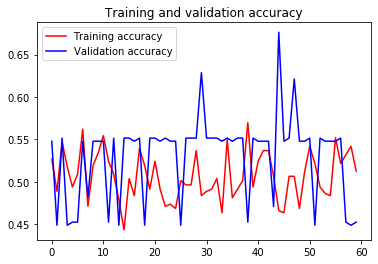

<Figure size 432x288 with 0 Axes>

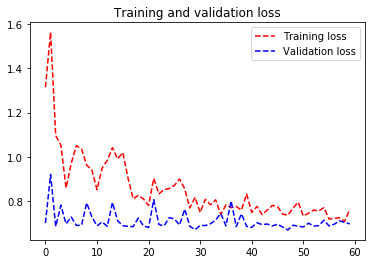

<Figure size 432x288 with 0 Axes>

In [10]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
#save the model
#filepath = './models/saved_VGG16_AL_fullretrainEfficient'
#model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

In [12]:
19*19*2560

924160

In [13]:
924160

924160